# Modelo de Regresión Regularizado

In [15]:
import sys, os
sys.path.append(os.getcwd().replace('/notebooks',''))  # Replace with current directory name

In [16]:
#===== Configuración regional =================================
import locale

# Name might vary with operating system.
locale.setlocale(locale.LC_ALL, 'es_ES')

locale._override_localeconv["thousands_sep"] = "."

#===== Librerías ==============================================
# Importing the Warnings library for better presentation
import warnings

# Importando la biblioteca pandas para manipulación y análisis de datos
import pandas as pd
# Importando NumPy para operaciones numéricas y manipulación de arreglos
import numpy as np
# Importando itertools para generar combinaciones de columnas
import itertools

# Importando matplotlib.pyplot para crear gráficos y visualizaciones
import matplotlib.pyplot as plt
# Importando Seaborn para visualización de datos estadísticos (opcional, pero puede complementar a Plotly)
import seaborn as sns
# Importando Plotly Express para visualizaciones interactivas de alto nivel y fáciles de usar
import plotly.express as px
# Importando Plotly Graph Objects para un control más detallado sobre las visualizaciones
import plotly.graph_objects as go
# Multiple graphs in a figure
from plotly.subplots import make_subplots

# Importando la función seasonal_decompose para la descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose

#===== Ajustes visualización gráficos ============================
warnings.filterwarnings('ignore', category=DeprecationWarning)
# Matplotlib inline to visualize Matplotlib graphs
%matplotlib inline

# Configuration to set so that all the Seaborn figures come out with this size
%config Inlinebackend.figure_format= 'retina'
warnings.resetwarnings()

# Set the Seaborn context to "poster" for larger text and figures
sns.set_context("poster")

# Set the default figure size for Seaborn plots
sns.set(rc={"figure.figsize": (12., 6.)})

# Set the Seaborn style to "whitegrid" for a white background with gridlines
sns.set_style("whitegrid")

#===== Librerías proyecto ============================
from utils.data import Datasets
from utils.eda import column_explore

#===== Librerías regresión ============================
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import root_mean_squared_error # ?????

In [17]:
ds = Datasets()
cash, fees = ds.get_datasets()
cash = ds.desglose_created_at(cash)
cash.rename(columns={'id': 'cash_request_id'}, inplace=True)
print(cash.columns)
print()
print(fees.columns)

Index(['cash_request_id', 'amount', 'status', 'created_at', 'updated_at',
       'user_id', 'moderated_at', 'deleted_account_id', 'reimbursement_date',
       'cash_request_received_date', 'money_back_date', 'transfer_type',
       'send_at', 'recovery_status', 'reco_creation', 'reco_last_update',
       'id_usuario', 'created_year', 'created_month', 'created_year_month',
       'created_dayofweek', 'created_hour'],
      dtype='object')

Index(['id', 'cash_request_id', 'type', 'status', 'category', 'total_amount',
       'reason', 'created_at', 'updated_at', 'paid_at', 'from_date', 'to_date',
       'charge_moment'],
      dtype='object')


In [18]:
# Tratamiento de Valores Faltantes
# La columna `category` tiene muy pocos valores: sólo está poblada cuando ha habido algún tipo de incidente (`fees['type']=='incident'`). Veremos cómo podemos poblar los valores faltantes para poder incluir este dato en nuestro análisis de regresión.
# fees[fees['category'].isna()].sample(20)
# fees['category'].fillna('ninguna', inplace=True)
fees['category'] = fees.apply(lambda row: row.category if row.category in ['rejected_direct_debit','month_delay_on_payment'] else row.type, axis=1)
print(fees.category.value_counts().sum())
fees.category.value_counts()


21061


category
instant_payment           11099
postpone                   7766
rejected_direct_debit      1599
month_delay_on_payment      597
Name: count, dtype: int64

In [19]:
# Selección de Características para la Regresión
subset_cash=['cash_request_id','amount','status','transfer_type','recovery_status','user_id','deleted_account_id','id_usuario','created_year_month','created_at','created_dayofweek','created_hour']
cash_ss = cash[subset_cash]
cash_ss

,cash_request_id,amount,status,transfer_type,recovery_status,user_id,deleted_account_id,id_usuario,created_year_month,created_at,created_dayofweek,created_hour
0,5,100.0,rejected,regular,NaN,804.0,NaN,804,2019-12,2019-12-10 19:05:21.596873+00:00,2,19
1,70,100.0,rejected,regular,NaN,231.0,NaN,231,2019-12,2019-12-10 19:50:12.347780+00:00,2,19
2,7,100.0,rejected,regular,NaN,191.0,NaN,191,2019-12,2019-12-10 19:13:35.825460+00:00,2,19
3,10,99.0,rejected,regular,NaN,761.0,NaN,761,2019-12,2019-12-10 19:16:10.880172+00:00,2,19
4,1594,100.0,rejected,regular,NaN,7686.0,NaN,7686,2020-5,2020-05-06 09:59:38.877376+00:00,3,9
...,...,...,...,...,...,...,...,...,...,...,...,...
23965,20616,100.0,money_back,instant,NaN,13681.0,NaN,13681,2020-10,2020-10-12 13:54:11.686225+00:00,1,13
23966,25243,50.0,money_back,instant,completed,NaN,30367.0,30367,2020-10,2020-10-27 14:41:25.734910+00:00,2,14
23967,22357,100.0,money_back,instant,NaN,82122.0,NaN,82122,2020-10,2020-10-20 07:58:04.006937+00:00,2,7
23968,20256,100.0,money_back,instant,NaN,64517.0,NaN,64517,2020-10,2020-10-10 05:40:55.700422+00:00,6,5


In [20]:
subset_fees=['id','cash_request_id','type', 'status', 'category', 'total_amount','charge_moment']
fees_ss = fees[subset_fees]
fees_ss

,id,cash_request_id,type,status,category,total_amount,charge_moment
0,6537,14941,instant_payment,rejected,instant_payment,5.0,after
1,6961,11714,incident,accepted,rejected_direct_debit,5.0,after
2,16296,23371,instant_payment,accepted,instant_payment,5.0,after
3,20775,26772,instant_payment,accepted,instant_payment,5.0,after
4,11242,19350,instant_payment,accepted,instant_payment,5.0,after
...,...,...,...,...,...,...,...
21056,12372,20262,instant_payment,rejected,instant_payment,5.0,after
21057,20768,26764,instant_payment,rejected,instant_payment,5.0,after
21058,18779,25331,instant_payment,rejected,instant_payment,5.0,after
21059,16542,23628,instant_payment,rejected,instant_payment,5.0,after


In [21]:
# Dataset Unificado para la Regresión
merged = pd.merge(cash_ss, fees_ss.add_prefix('fee_'), left_on='cash_request_id', right_on='fee_cash_request_id', how='outer') # 32098 rows

# metricas_usuario[metricas_usuario['deleted_account_id'].isna()] # 1309
merged[merged['user_id'].isna()]
merged['user_id'].fillna(0)
merged['existing_account'] = merged['user_id'].transform(lambda x: 1 if x > 0 else 0)
# merged['existing_account'].value_counts()

top1000 = merged[merged['status']=='money_back'].groupby('id_usuario').agg(
    amount_fees=('fee_total_amount','sum'))
top1000_usrs = top1000.sort_values(by='amount_fees', ascending=False).iloc[:1000].index
# top1000_usrs

top_users = merged[merged['id_usuario'].isin(top1000_usrs)].reset_index()
# top_users.info()

top_users.drop(columns=['recovery_status','deleted_account_id'], inplace=True)
top_users.drop(columns=['user_id'], inplace=True)

top_users.dropna(inplace=True, ignore_index=True)

In [22]:
# Beneficio por cliente
# Ojo relación 'fee_type' <-> 'fee_category'
metricas_usuario = top_users.groupby(['created_year_month','created_dayofweek','created_hour','id_usuario','existing_account','status',
        'transfer_type','fee_status','fee_category','fee_charge_moment']).agg(
    num_peticiones=('cash_request_id', 'count'),
    amount=('amount', 'sum'),
    num_fees=('fee_id','count'),
    amount_fees=('fee_total_amount','sum'))
print(metricas_usuario.shape)
metricas_usuario.sample(20)

(4221, 4)


num_peticiones  \
created_year_month created_dayofweek created_hour id_usuario existing_account status     transfer_type fee_status fee_category          fee_charge_moment                   
2020-7             5.0               21.0         14304.0    1                money_back regular       cancelled  postpone              after                           3   
2020-6             7.0               15.0         13252.0    1                money_back regular       accepted   postpone              before                          1   
2020-8             6.0               7.0          19055.0    1                money_back instant       accepted   postpone              before                          2   
2020-6             4.0               6.0          2562.0     1                money_back regular       cancelled  postpone              after                           5   
2020-10            7.0               11.0         14213.0    1                money_back instant       accepted   instant_payment       after                           1   
2020-9             3.0               14.0         26430.0    1                money_back instant       accepted   postpone              before                          1   
                   4.0               7.0          48706.0    1                money_back instant       accepted   instant_payment       after                           1   
2020-8             2.0               5.0          22159.0    1                money_back instant       accepted   instant_payment       after                           1   
2020-10            2.0               9.0          82336.0    1                money_back instant       cancelled  postpone              before                          6   
2020-9             4.0               14.0         19312.0    1                money_back instant       accepted   instant_payment       after                           1   
2020-7             4.0               5.0          21682.0    0                money_back regular       accepted   postpone              before                          1   
2020-10            1.0               22.0         15868.0    1                money_back instant       cancelled  postpone              before                          5   
                   2.0               21.0         2834.0     1                money_back instant       accepted   instant_payment       after                           1   
2020-6             1.0               3.0          30337.0    0                money_back regular       accepted   rejected_direct_debit after                           1   
2020-8             4.0               8.0          24732.0    1                money_back instant       cancelled  postpone              after                           1   
2020-7             3.0               10.0         26358.0    1                money_back regular       cancelled  postpone              after                           1   
                   2.0               19.0         19350.0    1                money_back regular       accepted   postpone              before                          1   
2020-8             3.0               5.0          6511.0     1                money_back instant       cancelled  postpone              after                           2   
2020-10            1.0               17.0         526.0      1                money_back instant       accepted   postpone              before                          1   
2020-7             3.0               16.0         17075.0    1                money_back regular       cancelled  postpone              after                           1   

                                                                                                                                                           amount  \
created_year_month created_dayofweek created_hour id_usuario existing_account status     transfer_type fee_status fee_category          fee_charge_moment           
2020-7            

In [23]:
# Regresión
df = metricas_usuario.reset_index()
df

,created_year_month,created_dayofweek,created_hour,id_usuario,existing_account,status,transfer_type,fee_status,fee_category,fee_charge_moment,num_peticiones,amount,num_fees,amount_fees
0,2020-10,1.0,1.0,13851.0,1,money_back,instant,accepted,instant_payment,after,1,100.0,1,5.0
1,2020-10,1.0,3.0,5189.0,1,money_back,instant,accepted,instant_payment,after,1,100.0,1,5.0
2,2020-10,1.0,3.0,5189.0,1,money_back,instant,accepted,postpone,before,1,100.0,1,5.0
3,2020-10,1.0,4.0,6410.0,1,money_back,instant,accepted,instant_payment,after,1,50.0,1,5.0
4,2020-10,1.0,4.0,6410.0,1,money_back,instant,accepted,postpone,before,1,50.0,1,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4216,2020-9,7.0,22.0,14443.0,1,money_back,instant,accepted,instant_payment,after,1,100.0,1,5.0
4217,2020-9,7.0,22.0,14443.0,1,money_back,instant,cancelled,postpone,after,2,200.0,2,10.0
4218,2020-9,7.0,22.0,16240.0,1,direct_debit_rejected,instant,rejected,instant_payment,after,1,50.0,1,5.0
4219,2020-9,7.0,23.0,39840.0,1,money_back,instant,accepted,instant_payment,after,1,30.0,1,5.0


In [24]:
df = ds.get_dummies_and_drop_cols(df, '', 'status')
df = ds.get_dummies_and_drop_cols(df, '', 'transfer_type')
df = ds.get_dummies_and_drop_cols(df, '', 'fee_status')
df = ds.get_dummies_and_drop_cols(df, '', 'fee_category')
df = ds.get_dummies_and_drop_cols(df, '', 'fee_charge_moment')

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df['created_year_month_dummy'] = labelencoder.fit_transform(df['created_year_month']) 
df

,created_year_month,created_dayofweek,created_hour,id_usuario,existing_account,num_peticiones,amount,num_fees,amount_fees,status_direct_debit_rejected,...,status_transaction_declined,transfer_type_regular,fee_status_cancelled,fee_status_confirmed,fee_status_rejected,fee_category_month_delay_on_payment,fee_category_postpone,fee_category_rejected_direct_debit,fee_charge_moment_before,created_year_month_dummy
0,2020-10,1.0,1.0,13851.0,1,1,100.0,1,5.0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-10,1.0,3.0,5189.0,1,1,100.0,1,5.0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-10,1.0,3.0,5189.0,1,1,100.0,1,5.0,0,...,0,0,0,0,0,0,1,0,1,0
3,2020-10,1.0,4.0,6410.0,1,1,50.0,1,5.0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020-10,1.0,4.0,6410.0,1,1,50.0,1,5.0,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4216,2020-9,7.0,22.0,14443.0,1,1,100.0,1,5.0,0,...,0,0,0,0,0,0,0,0,0,6
4217,2020-9,7.0,22.0,14443.0,1,2,200.0,2,10.0,0,...,0,0,1,0,0,0,1,0,0,6
4218,2020-9,7.0,22.0,16240.0,1,1,50.0,1,5.0,1,...,0,0,0,0,1,0,0,0,0,6
4219,2020-9,7.0,23.0,39840.0,1,1,30.0,1,5.0,0,...,0,0,0,0,0,0,0,0,0,6


In [25]:
# df.drop(columns=['num_peticiones','num_fees'], inplace=True)
# df.drop(columns=['id_usuario','num_peticiones','num_fees'], inplace=True)
df.drop(columns=['id_usuario','num_peticiones','num_fees','amount'], inplace=True)

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


<Axes: >

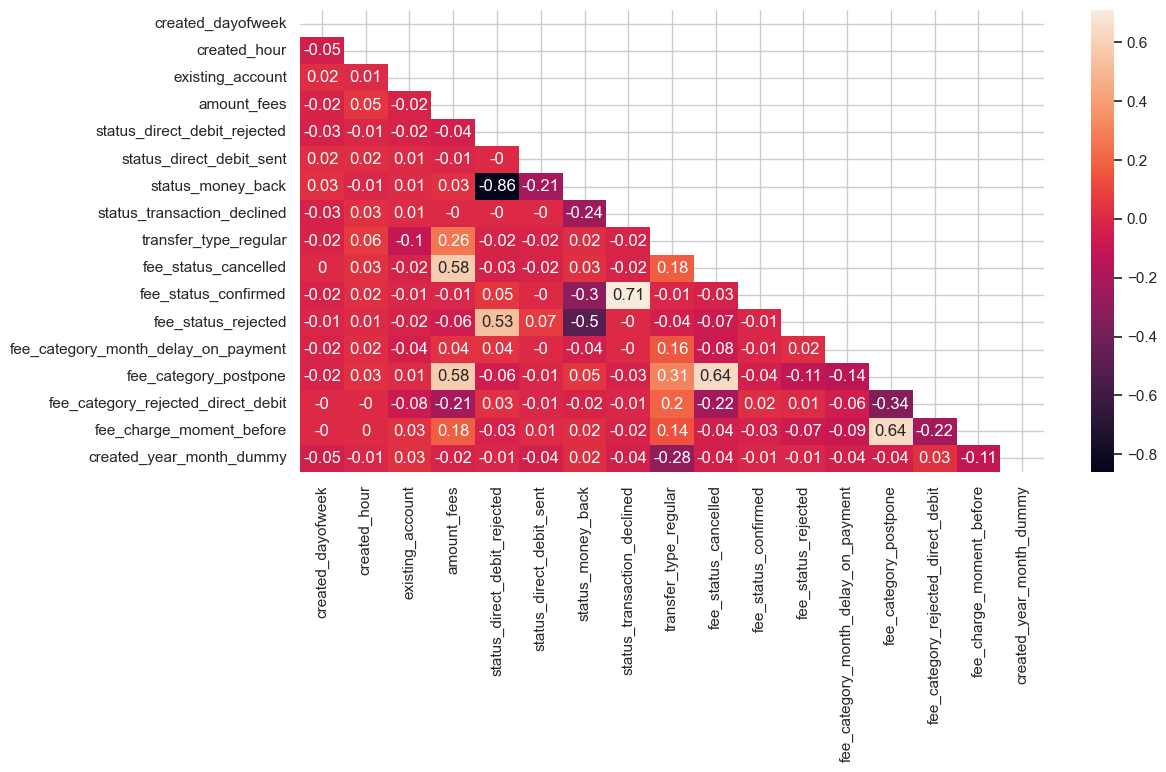

In [26]:
numericals = df.select_dtypes(np.number)
corr = numericals.corr(method='spearman') # pearson, kendall, spearman
import seaborn as sns
warnings.filterwarnings('ignore', category=DeprecationWarning)
sns.set_context("poster") # Set the Seaborn context to "poster" for larger text and figures
sns.set(rc={"figure.figsize": (12., 6.)}) # Set the default figure size for Seaborn plots
sns.set_style("whitegrid") # Set the Seaborn style to "whitegrid" for a white background with gridlines
warnings.resetwarnings()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr.round(2), mask=mask, annot=True)

In [27]:
# sns.scatterplot(data=df, x='amount', y='amount_fees', alpha=0.2)
fig = px.scatter(df, x='amount', y='amount_fees', opacity=0.2, title=f'Gráfico de dispersión de \'amount\' vs \'amount_fees\' con línea de tendencia', trendline="ols") # Agregar línea de tendencia (OLS)
# fig.update_traces(line=dict(color='red', width=2))
fig.update_traces(line=dict(color='red'), selector=dict(mode='lines')) # Cambiar el color de la línea de tendencia
fig.show()


ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['created_year_month', 'created_dayofweek', 'created_hour', 'existing_account', 'amount_fees', 'status_direct_debit_rejected', 'status_direct_debit_sent', 'status_money_back', 'status_transaction_declined', 'transfer_type_regular', 'fee_status_cancelled', 'fee_status_confirmed', 'fee_status_rejected', 'fee_category_month_delay_on_payment', 'fee_category_postpone', 'fee_category_rejected_direct_debit', 'fee_charge_moment_before', 'created_year_month_dummy'] but received: amount

In [28]:
# sns.scatterplot(data=df, x='amount', y='amount_fees', alpha=0.2)
# plt.xlim(-4, 500)
# plt.ylim(-1, 1)

fig = px.scatter(df, x='amount', y='amount_fees', opacity=0.2, range_x=[-5, 500], title=f'Gráfico de dispersión de \'amount\' vs \'amount_fees\' con línea de tendencia', trendline="ols") # Agregar línea de tendencia (OLS)
# fig.update_traces(line=dict(color='red', width=2))
fig.update_traces(line=dict(color='red'), selector=dict(mode='lines')) # Cambiar el color de la línea de tendencia
fig.show()




ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['created_year_month', 'created_dayofweek', 'created_hour', 'existing_account', 'amount_fees', 'status_direct_debit_rejected', 'status_direct_debit_sent', 'status_money_back', 'status_transaction_declined', 'transfer_type_regular', 'fee_status_cancelled', 'fee_status_confirmed', 'fee_status_rejected', 'fee_category_month_delay_on_payment', 'fee_category_postpone', 'fee_category_rejected_direct_debit', 'fee_charge_moment_before', 'created_year_month_dummy'] but received: amount

In [29]:
df_previous = pd.DataFrame(df[df['created_year_month']!='2020-10'])
df_previous.drop(columns=['created_year_month'], inplace=True)
df_previous

,created_dayofweek,created_hour,existing_account,amount_fees,status_direct_debit_rejected,status_direct_debit_sent,status_money_back,status_transaction_declined,transfer_type_regular,fee_status_cancelled,fee_status_confirmed,fee_status_rejected,fee_category_month_delay_on_payment,fee_category_postpone,fee_category_rejected_direct_debit,fee_charge_moment_before,created_year_month_dummy
932,7.0,4.0,1,5.0,0,0,1,0,0,0,0,0,0,0,0,0,1
933,7.0,8.0,1,5.0,0,0,1,0,0,0,0,0,0,0,0,0,1
934,7.0,8.0,1,5.0,0,0,1,0,0,0,0,0,0,0,0,0,1
935,7.0,8.0,1,5.0,0,0,1,0,0,0,0,0,0,0,0,0,1
936,7.0,8.0,1,5.0,0,0,1,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4216,7.0,22.0,1,5.0,0,0,1,0,0,0,0,0,0,0,0,0,6
4217,7.0,22.0,1,10.0,0,0,1,0,0,1,0,0,0,1,0,0,6
4218,7.0,22.0,1,5.0,1,0,0,0,0,0,0,1,0,0,0,0,6
4219,7.0,23.0,1,5.0,0,0,1,0,0,0,0,0,0,0,0,0,6


In [30]:
df_last = pd.DataFrame(df[df['created_year_month']=='2020-10'])
df_last.drop(columns=['created_year_month'], inplace=True)
df_last

,created_dayofweek,created_hour,existing_account,amount_fees,status_direct_debit_rejected,status_direct_debit_sent,status_money_back,status_transaction_declined,transfer_type_regular,fee_status_cancelled,fee_status_confirmed,fee_status_rejected,fee_category_month_delay_on_payment,fee_category_postpone,fee_category_rejected_direct_debit,fee_charge_moment_before,created_year_month_dummy
0,1.0,1.0,1,5.0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1.0,3.0,1,5.0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,1.0,3.0,1,5.0,0,0,1,0,0,0,0,0,0,1,0,1,0
3,1.0,4.0,1,5.0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,1.0,4.0,1,5.0,0,0,1,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
927,7.0,21.0,1,5.0,0,0,1,0,0,0,0,0,0,0,0,0,0
928,7.0,21.0,1,5.0,0,0,1,0,0,1,0,0,0,1,0,0,0
929,7.0,21.0,1,15.0,0,0,1,0,0,1,0,0,0,1,0,1,0
930,7.0,23.0,1,5.0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [32]:
# Definir una semilla para reproducibilidad
seed = 42

# Definir predictores y variable dependiente/objetivo
X=df_previous.drop(columns='amount_fees')
y=df_previous['amount_fees']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=None, random_state=seed)

# Entrenar modelo
model = LinearRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)

# Sobrescribir conjuntos de prueba X_test y y_test con los valores de nuestro 3r mes
X_test = df_last.drop(columns='amount_fees')
y_test = df_last['amount_fees']

y_test_pred = model.predict(X_test)

# Evaluar el Modelo
print('-- Train -----')
mse_train = mean_squared_error(y_train, y_train_pred)
print(f"Error cuadrático medio (MSE) del modelo: {mse_train:.4f}")
r2score_train = r2_score(y_train, y_train_pred)
print(f"Valor R² del modelo: {r2score_train:.4f}")
print()

print('-- Test -----')
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Error cuadrático medio (MSE) del modelo: {mse_test:.4f}")
r2score_test = r2_score(y_test, y_test_pred)
print(f"Valor R² del modelo: {r2score_test:.4f}")
print()


-- Train -----
Error cuadrático medio (MSE) del modelo: 35.7832
Valor R² del modelo: 0.2696

-- Test -----
Error cuadrático medio (MSE) del modelo: 23.7589
Valor R² del modelo: 0.1459



<>:9: SyntaxWarning: invalid escape sequence '\h'
<>:18: SyntaxWarning: invalid escape sequence '\h'
<>:9: SyntaxWarning: invalid escape sequence '\h'
<>:18: SyntaxWarning: invalid escape sequence '\h'
/var/folders/3h/d4zpwm_x4qg78bc5337r4q240000gq/T/ipykernel_61111/961123418.py:9: SyntaxWarning: invalid escape sequence '\h'
  axs[0].set_ylabel('$\hat y$')
/var/folders/3h/d4zpwm_x4qg78bc5337r4q240000gq/T/ipykernel_61111/961123418.py:18: SyntaxWarning: invalid escape sequence '\h'
  axs[1].set_ylabel('$\hat y$')


Text(0.5, 0.98, 'Predicciones vs Valores Reales')

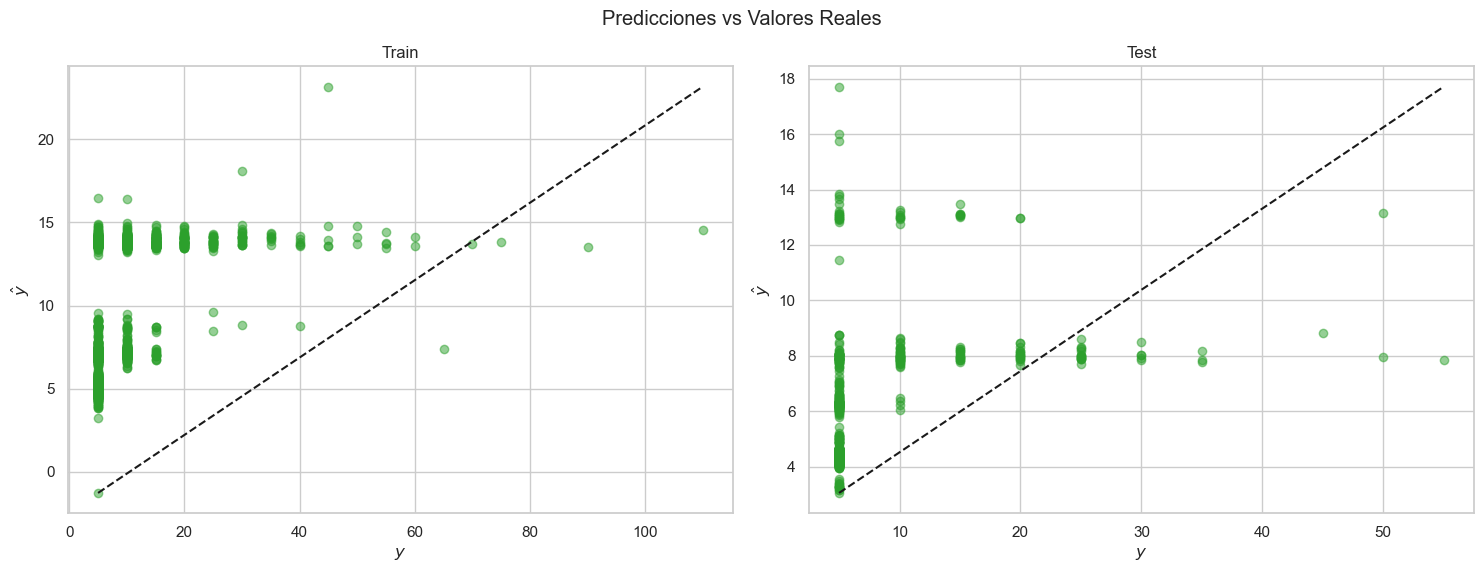

In [33]:
# Gráfico de Predicciones vs. Valores Reales
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].scatter(y_train, y_train_pred, c='tab:green', alpha=0.5)
axs[0].plot([y_train.min(), y_train.max()], [y_train_pred.min(), y_train_pred.max()], '--k')
axs[0].set_title('Train')
# warnings.filterwarnings('ignore', category=SyntaxWarning)
axs[0].set_xlabel('$y$')
axs[0].set_ylabel('$\hat y$')
# axs[0].set_ylabel(r'$\^ y$')
# warnings.resetwarnings()

axs[1].scatter(y_test, y_test_pred, c='tab:green', alpha=0.5)
axs[1].plot([y_test.min(), y_test.max()], [y_test_pred.min(), y_test_pred.max()], '--k')
axs[1].set_title('Test')
# warnings.filterwarnings('ignore', category=SyntaxWarning)
axs[1].set_xlabel('$y$')
axs[1].set_ylabel('$\hat y$')
# warnings.resetwarnings()

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) #rect=[left, bottom, right, top]
fig.suptitle('Predicciones vs Valores Reales')

<>:8: SyntaxWarning: invalid escape sequence '\h'
<>:9: SyntaxWarning: invalid escape sequence '\h'
<>:16: SyntaxWarning: invalid escape sequence '\h'
<>:17: SyntaxWarning: invalid escape sequence '\h'
<>:8: SyntaxWarning: invalid escape sequence '\h'
<>:9: SyntaxWarning: invalid escape sequence '\h'
<>:16: SyntaxWarning: invalid escape sequence '\h'
<>:17: SyntaxWarning: invalid escape sequence '\h'
/var/folders/3h/d4zpwm_x4qg78bc5337r4q240000gq/T/ipykernel_61111/2979888543.py:8: SyntaxWarning: invalid escape sequence '\h'
  axs[0].set_xlabel('$\hat y$')
/var/folders/3h/d4zpwm_x4qg78bc5337r4q240000gq/T/ipykernel_61111/2979888543.py:9: SyntaxWarning: invalid escape sequence '\h'
  axs[0].set_ylabel('$y - \hat y$')
/var/folders/3h/d4zpwm_x4qg78bc5337r4q240000gq/T/ipykernel_61111/2979888543.py:16: SyntaxWarning: invalid escape sequence '\h'
  axs[1].set_xlabel('$\hat y$')
/var/folders/3h/d4zpwm_x4qg78bc5337r4q240000gq/T/ipykernel_61111/2979888543.py:17: SyntaxWarning: invalid escape sequ

Text(0.5, 0.98, 'Gráfico de Residuos')

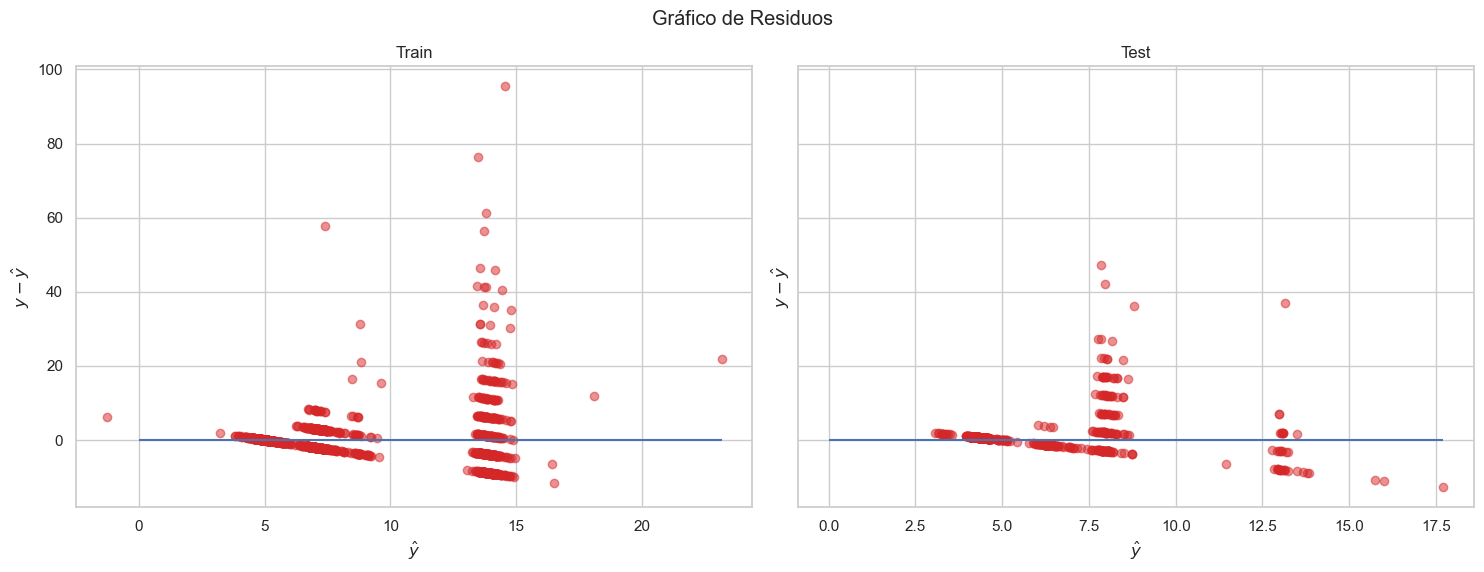

In [34]:
# Análisis de Residuos
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

axs[0].scatter(x=y_train_pred, y=y_train - y_train_pred, c='tab:red', alpha=0.5)
axs[0].hlines(y=0, xmin=0, xmax=y_train_pred.max())
axs[0].set_title('Train')
warnings.filterwarnings('ignore', category=SyntaxWarning)
axs[0].set_xlabel('$\hat y$')
axs[0].set_ylabel('$y - \hat y$')
warnings.resetwarnings()

axs[1].scatter(x=y_test_pred, y=y_test - y_test_pred, c='tab:red', alpha=0.5)
axs[1].hlines(y=0, xmin=0, xmax=y_test_pred.max())
axs[1].set_title('Test')
warnings.filterwarnings('ignore', category=SyntaxWarning)
axs[1].set_xlabel('$\hat y$')
axs[1].set_ylabel('$y - \hat y$')
warnings.resetwarnings()

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) #rect=[left, bottom, right, top]
fig.suptitle('Gráfico de Residuos')


Intercepto del modelo: 14.41571559580623

Coeficientes del modelo de LinearRegression:
 [-5.41790220e-02  1.72810375e-02 -6.43287191e-01 -1.01667151e+01
 -7.99360578e-15 -9.41560226e+00 -3.55271368e-15  5.75028812e-01
  1.69587862e+00 -6.39047568e+00 -2.41608015e-01  1.67551560e+00
  6.99104769e+00 -2.22997267e-01 -5.06600877e+00  1.13431534e-01]

created_dayofweek                     -5.417902e-02
created_hour                           1.728104e-02
existing_account                      -6.432872e-01
status_direct_debit_rejected          -1.016672e+01
status_direct_debit_sent              -7.993606e-15
status_money_back                     -9.415602e+00
status_transaction_declined           -3.552714e-15
transfer_type_regular                  5.750288e-01
fee_status_cancelled                   1.695879e+00
fee_status_confirmed                  -6.390476e+00
fee_status_rejected                   -2.416080e-01
fee_category_month_delay_on_payment    1.675516e+00
fee_category_postpone    

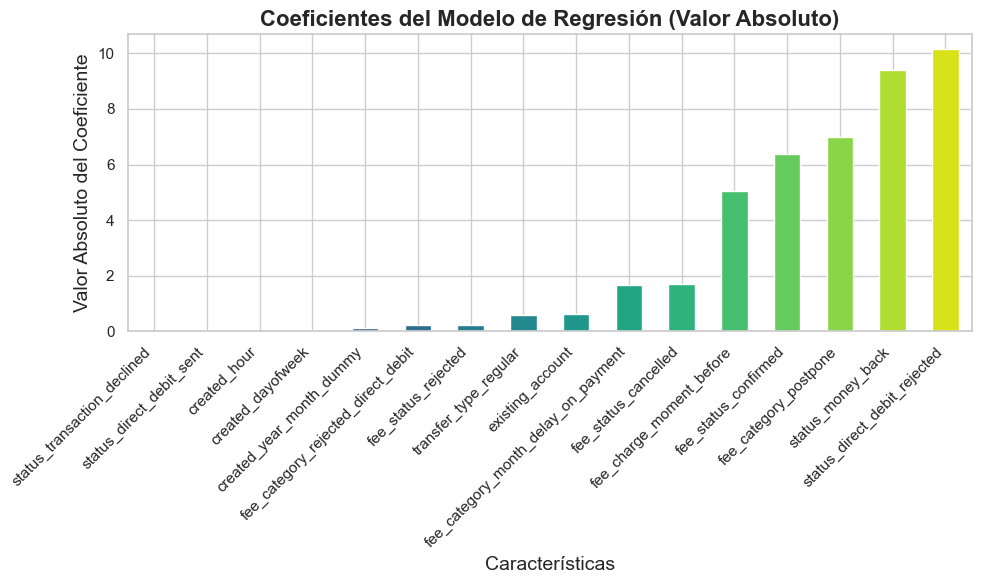

In [35]:
# Coeficientes
print('\nIntercepto del modelo:', model.intercept_)
print('\nCoeficientes del modelo de LinearRegression:\n', model.coef_)
print()

features = X.columns

print(pd.Series(model.coef_, index=features))

# Crear la gráfica de barras ordenada por valores absolutos de los coeficientes
plt.figure(figsize=(10, 6))

# Obtener los coeficientes de regresión
coefs_lr = pd.Series(np.abs(model.coef_), index=features).sort_values() # Valores absolutos para ordenarlos

# Ordenar los coeficientes de menor a mayor (invirtiendo el orden)
coefs_lr.sort_values(ascending=True).plot(kind='bar', color=sns.color_palette("viridis", n_colors=len(coefs_lr)))

# Título y etiquetas de ejes
plt.title('Coeficientes del Modelo de Regresión (Valor Absoluto)', fontsize=16, weight='bold')
plt.xlabel('Características', fontsize=14)
plt.ylabel('Valor Absoluto del Coeficiente', fontsize=14)

# Rotación y alineación de las etiquetas para mejor legibilidad
plt.xticks(rotation=45, ha='right')

# Ajustar el espaciado para evitar solapamiento de elementos
plt.tight_layout()

# Mostrar la gráfica
plt.show()


Intercepto del modelo: 11.521850902140654

Coeficientes del modelo Ridge:
 [-0.05536674  0.01750283 -0.63080647 -7.07533127  0.         -6.5519167
  0.          0.58901378  1.88448906 -3.36414638 -0.15682393  1.66211892
  6.77966241 -0.23672839 -4.86339878  0.11796564]

Error Cuadrático Medio (MSE) en entrenamiento: 35.80464937217305
Error Cuadrático Medio (MSE) en prueba: 23.200863302822462

Puntaje R^2 en entrenamiento: 0.26914240941137846
Puntaje R^2 en prueba: 0.16599358813307652


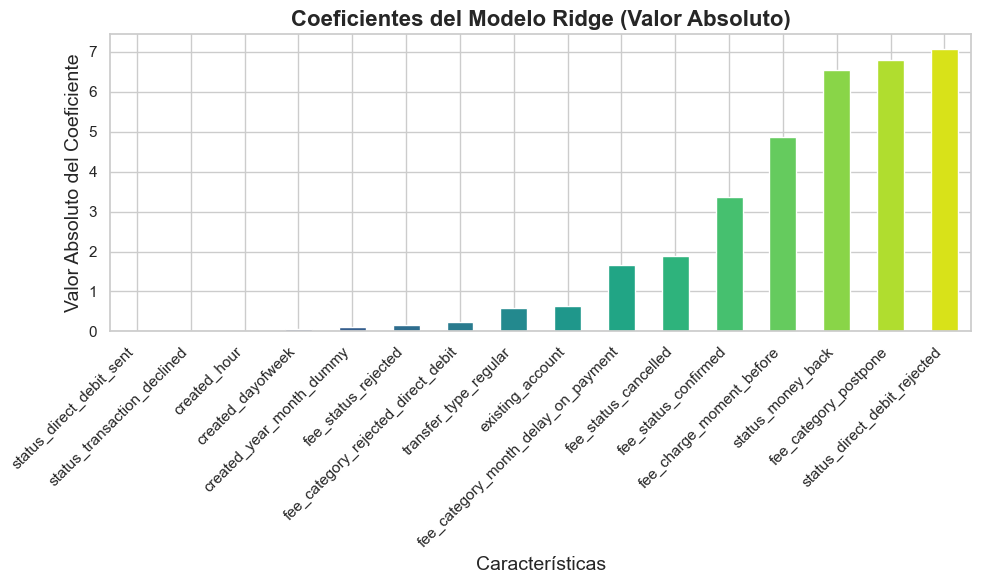

In [36]:
## Regularización de Ridge
from sklearn import linear_model # Para la regresión Ridge
ridge = linear_model.Ridge(alpha=1) # Inicializamos el regresor Ridge con una penalización de 1
ridge.fit(X_train, y_train) # Ajustamos el modelo a los datos de entrenamiento

# Extraemos los coeficientes y los ordenamos en función de su valor absoluto
coefs_ridge = pd.Series(np.abs(ridge.coef_), index=features).sort_values(ascending=False)

# Realizamos la predicción en el conjunto de prueba y entrenamiento
y_train_pred_ridge = ridge.predict(X_train)
y_test_pred_ridge = ridge.predict(X_test)

# Evaluación del modelo: calculamos el Error Cuadrático Medio (MSE) y el R^2
mse_ridge_train = mean_squared_error(y_train, y_train_pred_ridge) # MSE en entrenamiento
mse_ridge_test = mean_squared_error(y_test, y_test_pred_ridge) # MSE en prueba
r2score_ridge_train = ridge.score(X_train, y_train) # R^2 en entrenamiento
r2score_ridge_test = ridge.score(X_test, y_test) # R^2 en prueba

# Mostramos los resultados:
print('\nIntercepto del modelo:', ridge.intercept_)
print('\nCoeficientes del modelo Ridge:\n', ridge.coef_)
print('\nError Cuadrático Medio (MSE) en entrenamiento:', mse_ridge_train)
print('Error Cuadrático Medio (MSE) en prueba:', mse_ridge_test)
print('\nPuntaje R^2 en entrenamiento:', r2score_ridge_train)
print('Puntaje R^2 en prueba:', r2score_ridge_test)

# Graficamos los coeficientes ordenados por valor absoluto
plt.figure(figsize=(10, 6))
# Ordenar los coeficientes de menor a mayor (invirtiendo el orden)
coefs_ridge.sort_values(ascending=True).plot(kind='bar', color=sns.color_palette("viridis", n_colors=len(coefs_ridge)))

# Añadimos el título y etiquetas a los ejes
plt.title('Coeficientes del Modelo Ridge (Valor Absoluto)', fontsize=16, weight='bold')
plt.xlabel('Características', fontsize=14)
plt.ylabel('Valor Absoluto del Coeficiente', fontsize=14)

# Ajustamos las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=45, ha='right')

# Ajuste del espaciado para evitar solapamientos
plt.tight_layout()

# Mostramos la gráfica con un diseño ajustado
plt.show()


Intercepto del modelo: 7.017258921153007

Coeficientes del modelo Lasso:
 [-0.00000000e+00  6.92085550e-04 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.45661131e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  1.50662034e-01 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00]

Error Cuadrático Medio (MSE) en entrenamiento: 42.49190773983371
Error Cuadrático Medio (MSE) en prueba: 23.4653772630228

Puntaje R^2 en entrenamiento: 0.13263964723014843
Puntaje R^2 en prueba: 0.1564850480431672


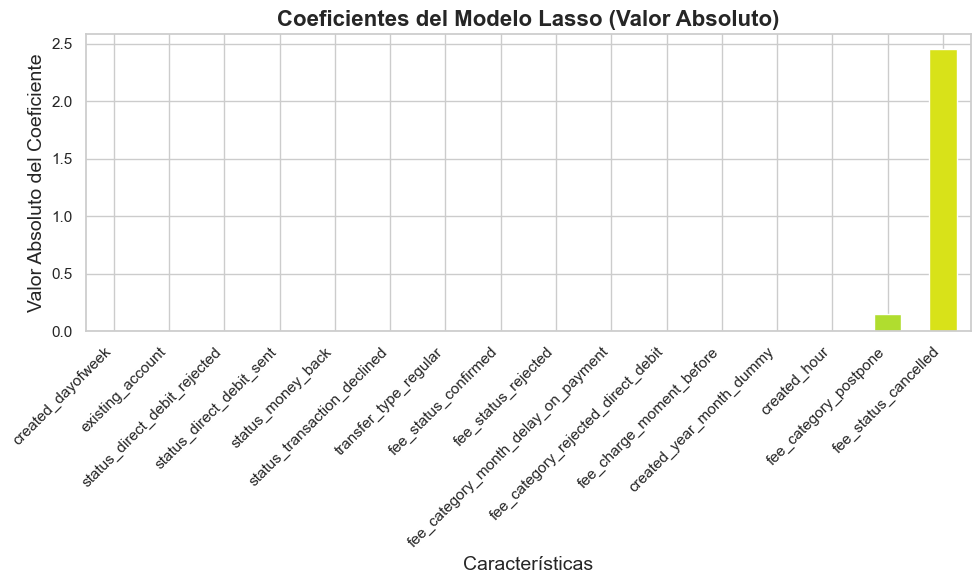

In [37]:
## Regularización de Lasso
lasso = linear_model.Lasso(alpha=1) # Inicializamos el regresor Lasso con una penalización de 1
lasso.fit(X_train, y_train) # Ajustamos el modelo a los datos de entrenamiento

# Extraemos los coeficientes y los ordenamos en función de su valor absoluto
coefs_lasso = pd.Series(np.abs(lasso.coef_), index=features).sort_values(ascending=False)

# Realizamos la predicción en los conjuntos de entrenamiento y prueba
y_train_pred_lasso = lasso.predict(X_train)
y_test_pred_lasso = lasso.predict(X_test)

# Evaluación del modelo: calculamos el Error Cuadrático Medio (MSE) y el R^2
mse_lasso_train = mean_squared_error(y_train, y_train_pred_lasso) # MSE en entrenamiento
mse_lasso_test = mean_squared_error(y_test, y_test_pred_lasso) # MSE en prueba
r2score_lasso_train = lasso.score(X_train, y_train) # R^2 en entrenamiento
r2score_lasso_test = lasso.score(X_test, y_test) # R^2 en prueba

# Mostramos los resultados:
print('\nIntercepto del modelo:', lasso.intercept_) # Imprimir el intercepto del modelo Lasso
print('\nCoeficientes del modelo Lasso:\n', lasso.coef_) # Imprimir los coeficientes del modelo Lasso
print('\nError Cuadrático Medio (MSE) en entrenamiento:', mse_lasso_train)
print('Error Cuadrático Medio (MSE) en prueba:', mse_lasso_test)
print('\nPuntaje R^2 en entrenamiento:', r2score_lasso_train)
print('Puntaje R^2 en prueba:', r2score_lasso_test)

# Graficamos los coeficientes ordenados por valor absoluto
plt.figure(figsize=(10, 6))

# Ordenar los coeficientes de menor a mayor (invirtiendo el orden)
coefs_lasso.sort_values(ascending=True).plot(kind='bar', color=sns.color_palette("viridis", n_colors=len(coefs_lasso)))

# Añadimos el título y etiquetas a los ejes
plt.title('Coeficientes del Modelo Lasso (Valor Absoluto)', fontsize=16, weight='bold')
plt.xlabel('Características', fontsize=14)
plt.ylabel('Valor Absoluto del Coeficiente', fontsize=14)

# Ajustamos las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=45, ha='right')

# Mostramos la gráfica con un diseño ajustado
plt.tight_layout() # Ajuste del espaciado para evitar solapamientos
plt.show()

In [38]:
# Comparación de Regresión, Ridge y Lasso
# Cálculo de las métricas R² y MSE para cada modelo
scores = [
    [r2score_train, r2score_test, r2score_train - r2score_test, mse_train, mse_test, mse_train - mse_test], # Regresión Lineal
    [r2score_ridge_train, r2score_ridge_test, r2score_ridge_train - r2score_ridge_test, mse_ridge_train, mse_ridge_test, mse_ridge_train - mse_ridge_test], # Ridge
    [r2score_lasso_train, r2score_lasso_test, r2score_lasso_train - r2score_lasso_test, mse_lasso_train, mse_lasso_test, mse_lasso_train - mse_lasso_test] # Lasso
]

# Creación del DataFrame con las métricas calculadas
df_scores = pd.DataFrame(scores,
    columns=["R² Entrenamiento", "R² Prueba", "Δ R² (Entrenamiento - Prueba)", "MSE Entrenamiento", "MSE Prueba", "Δ MSE (Entrenamiento - Prueba)"],
    index=["Sin regularización", "Ridge", "Lasso"])

# Mostramos el DataFrame con los puntajes R² y MSE para comparar entre los modelos
df_scores # Visualizamos la comparación de puntajes R² y MSE entre los tres modelos, incluyendo sus diferencias

,R² Entrenamiento,R² Prueba,Δ R² (Entrenamiento - Prueba),MSE Entrenamiento,MSE Prueba,Δ MSE (Entrenamiento - Prueba)
Sin regularización,0.269580,0.145935,0.123646,35.783193,23.758874,12.024320
Ridge,0.269142,0.165994,0.103149,35.804649,23.200863,12.603786
Lasso,0.132640,0.156485,-0.023845,42.491908,23.465377,19.026530


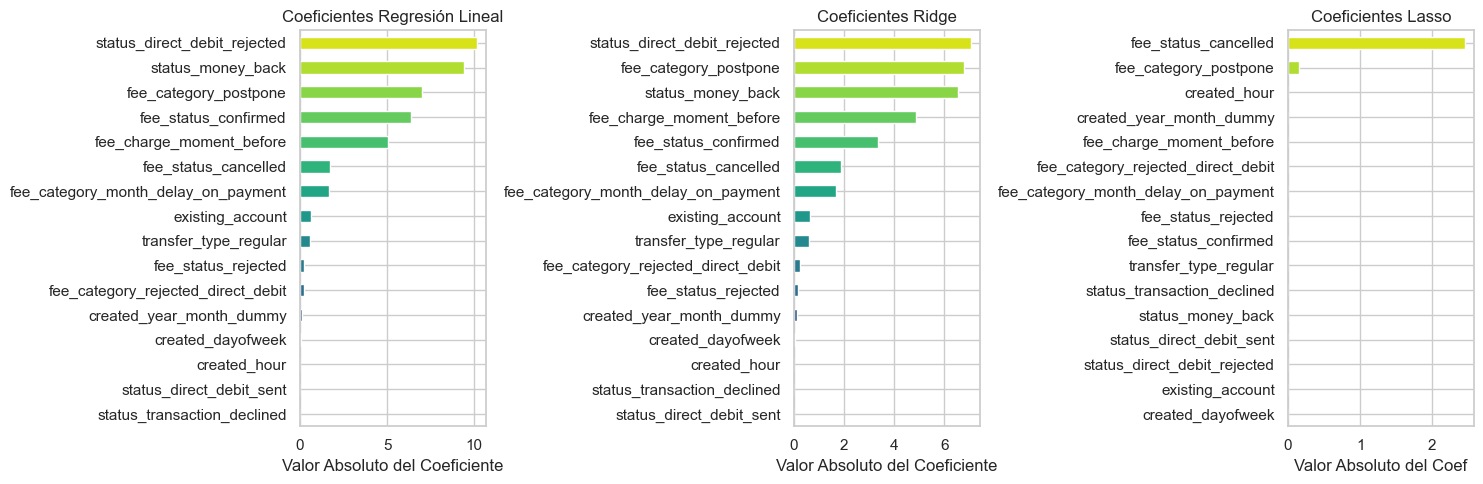

In [39]:
# Crear una figura de tamaño adecuado para visualizar los coeficientes
f = plt.figure(figsize=(15,5))
# Agregar los subgráficos
ax1 = f.add_subplot(131) # Primer gráfico para los coeficientes de la regresión lineal
ax2 = f.add_subplot(132) # Segundo gráfico para los coeficientes de Ridge
ax3 = f.add_subplot(133) # Tercer gráfico para los coeficientes de Lasso
# Graficar los coeficientes de cada modelo utilizando barras horizontales, ordenados de manera ascendente (menor a mayor)
coefs_lr.sort_values(ascending=True).plot(kind="barh", title='Coeficientes Regresión Lineal', ax=ax1, color=sns.color_palette("viridis", n_colors=len(coefs_lr))) # Coeficientes del modelo de regresión lineal
coefs_ridge.sort_values(ascending=True).plot(kind="barh", title='Coeficientes Ridge', ax=ax2, color=sns.color_palette("viridis", n_colors=len(coefs_ridge))) # Coeficientes del modelo Ridge
coefs_lasso.sort_values(ascending=True).plot(kind="barh", title='Coeficientes Lasso', ax=ax3, color=sns.color_palette("viridis", n_colors=len(coefs_lasso))) # Coeficientes del modelo Lasso
# Establecer etiquetas del eje X para cada gráfico
ax1.set_xlabel('Valor Absoluto del Coeficiente') # Etiqueta del eje X para el gráfico de regresión lineal
ax2.set_xlabel('Valor Absoluto del Coeficiente') # Etiqueta del eje X para el gráfico de Ridge
ax3.set_xlabel('Valor Absoluto del Coef') # Etiqueta del eje X para el gráfico de Lasso
# Ajustar el espaciado entre los gráficos para que no se superpongan
plt.tight_layout()
# Mostrar la figura con los tres gráficos comparativos
plt.show()

In [40]:
# Regresión con Estandarización
# Observar los valores máximos, mínimos, promedio y varianza de nuestros predictores
import pandas as pd
import numpy as np
# Crear una lista para almacenar los resultados
estadisticas = []

# Iterar sobre los predictores y calcular las estadísticas
for i, feat in enumerate(features):
    minimo = np.min(X.loc[:, feat])
    maximo = np.max(X.loc[:, feat])
    media = np.mean(X.loc[:, feat])
    varianza = np.var(X.loc[:, feat])
    # Añadir los resultados a la lista
    estadisticas.append([feat, minimo, maximo, media, varianza])

# Crear un DataFrame para mostrar los resultados
df_estadisticas = pd.DataFrame(estadisticas, columns=['Predictores', 'Mínimo', 'Máximo', 'Media', 'Varianza'])
# Mostrar el DataFrame
df_estadisticas


,Predictores,Mínimo,Máximo,Media,Varianza
0,created_dayofweek,1.0,7.0,3.757373,3.323923
1,created_hour,0.0,23.0,12.574339,28.200083
2,existing_account,0.0,1.0,0.935543,0.060303
3,status_direct_debit_rejected,0.0,1.0,0.009729,0.009635
4,status_direct_debit_sent,0.0,0.0,0.000000,0.000000
5,status_money_back,0.0,1.0,0.987838,0.012014
6,status_transaction_declined,0.0,0.0,0.000000,0.000000
7,transfer_type_regular,0.0,1.0,0.349042,0.227212
8,fee_status_cancelled,0.0,1.0,0.269991,0.197096
9,fee_status_confirmed,0.0,1.0,0.001216,0.001215


In [41]:
# # Importar bibliotecas necesarias
# import pandas as pd
from sklearn.preprocessing import StandardScaler
# import numpy as np
# Ajustar el StandardScaler y transformar los datos de entrenamiento
scalerX = StandardScaler().fit(X_train)
X_train_std = scalerX.transform(X_train)
X_test_std = scalerX.transform(X_test)
# # Crear un DataFrame para mostrar las estadísticas antes y después de la transformación
# stats_before = {
#     'Mínimo': [np.min(X_train), np.min(X_test)],
#     'Máximo': [np.max(X_train), np.max(X_test)],
#     'Media': [np.mean(X_train), np.mean(X_test)],
#     'Varianza': [np.var(X_train), np.var(X_test)]
# }
# stats_after = {
#     'Mínimo': [np.min(X_train_std), np.min(X_test_std)],
#     'Máximo': [np.max(X_train_std), np.max(X_test_std)],
#     'Media': [np.mean(X_train_std), np.mean(X_test_std)],
#     'Varianza': [np.var(X_train_std), np.var(X_test_std)]
# }

# # df_before = pd.DataFrame(stats_before, index=['Entrenamiento', 'Prueba'])
# # df_after = pd.DataFrame(stats_after, index=['Entrenamiento', 'Prueba'])

# # Mostrar ambos DataFrames
# print("\nEstadísticas antes de la transformación:")
# df_before

In [42]:
# print("\nEstadísticas después de la transformación:")
# df_after

In [43]:
# Observar los valores máximos, mínimos, promedio y varianza de nuestros predictores
import pandas as pd
import numpy as np
# Crear una lista para almacenar los resultados
estadisticas = []


# Ojo!!! Aquí no podemos hacer .loc[:, feat] como hacíamos antes porque X_train_std no es un DataFrame sino una Serie
# Iterar sobre los predictores y calcular las estadísticas
for i, feat in enumerate(features):
    minimo = np.min(X_train_std[:, i])
    maximo = np.max(X_train_std[:, i])
    media = np.mean(X_train_std[:, i])
    varianza = np.var(X_train_std[:, i])
    # Añadir los resultados a la lista
    estadisticas.append([feat, minimo, maximo, media, varianza])

# Crear un DataFrame para mostrar los resultados
df_estadisticas = pd.DataFrame(estadisticas, columns=['Predictores', 'Mínimo', 'Máximo', 'Media', 'Varianza'])
# Mostrar el DataFrame
df_estadisticas


,Predictores,Mínimo,Máximo,Media,Varianza
0,created_dayofweek,-1.510990,1.752748,5.186443e-17,1.0
1,created_hour,-2.373503,1.962654,1.066102e-16,1.0
2,existing_account,-3.821988,0.261644,-1.930509e-16,1.0
3,status_direct_debit_rejected,-0.101201,9.881295,-5.762715e-18,1.0
4,status_direct_debit_sent,0.000000,0.000000,0.000000e+00,0.0
5,status_money_back,-8.721382,0.114661,2.218645e-16,1.0
6,status_transaction_declined,0.000000,0.000000,0.000000e+00,0.0
7,transfer_type_regular,-0.712274,1.403953,-7.203394e-17,1.0
8,fee_status_cancelled,-0.600772,1.664525,-3.745765e-17,1.0
9,fee_status_confirmed,-0.034900,28.653098,-7.923733e-18,1.0


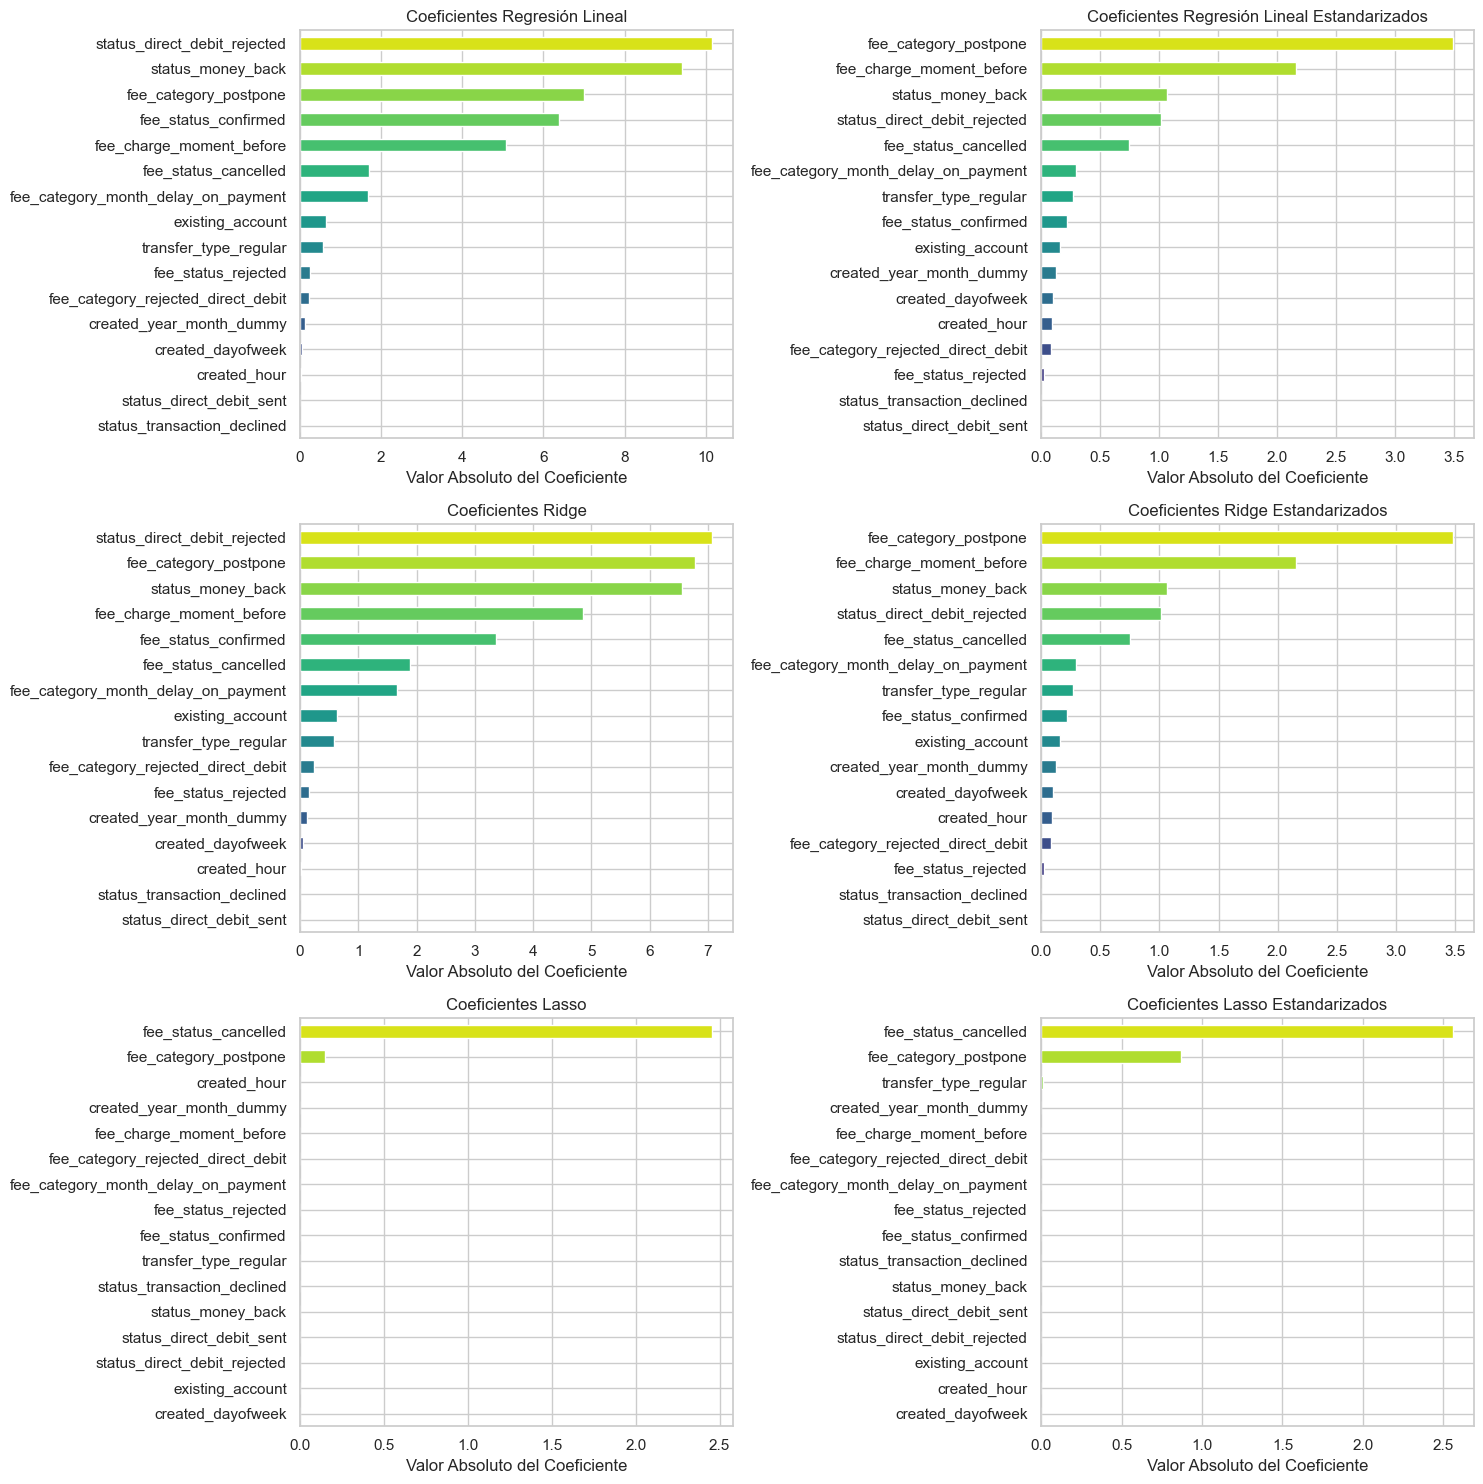

In [44]:
# Entrenar modelos
lr_std = linear_model.LinearRegression()
ridge_std = linear_model.Ridge(alpha=.3)
lasso_std = linear_model.Lasso(alpha=.3)

lr_std.fit(X_train_std, y_train)
ridge_std.fit(X_train_std, y_train)
lasso_std.fit(X_train_std, y_train)

# Coeficientes de regresión
coefs_lr_std = pd.Series(np.abs(lr_std.coef_), features).sort_values()
coefs_ridge_std = pd.Series(np.abs(ridge_std.coef_), features).sort_values()
coefs_lasso_std = pd.Series(np.abs(lasso_std.coef_), features).sort_values()

# Crear una figura de tamaño adecuado para visualizar los coeficientes en una disposición de 3x2
f = plt.figure(figsize=(15, 15))
# Agregar los subgráficos para cada modelo y cada tipo de coeficiente
ax1 = f.add_subplot(321) # Gráfico de coeficientes de regresión lineal
ax2 = f.add_subplot(322) # Gráfico de coeficientes estandarizados de regresión lineal
ax3 = f.add_subplot(323) # Gráfico de coeficientes de Ridge
ax4 = f.add_subplot(324) # Gráfico de coeficientes estandarizados de Ridge
ax5 = f.add_subplot(325) # Gráfico de coeficientes de Lasso
ax6 = f.add_subplot(326) # Gráfico de coeficientes estandarizados de Lasso
# Graficar los coeficientes de cada modelo utilizando barras horizontales, ordenados de menor a mayor
coefs_lr.sort_values(ascending=True).plot(
    kind="barh", title='Coeficientes Regresión Lineal', ax=ax1,
    color=sns.color_palette("viridis", n_colors=len(coefs_lr))
    )
coefs_lr_std.sort_values(ascending=True).plot(
    kind="barh", title='Coeficientes Regresión Lineal Estandarizados', ax=ax2,
    color=sns.color_palette("viridis", n_colors=len(coefs_lr_std))
    )
coefs_ridge.sort_values(ascending=True).plot(
    kind="barh", title='Coeficientes Ridge', ax=ax3,
    color=sns.color_palette("viridis", n_colors=len(coefs_ridge))
    )
coefs_ridge_std.sort_values(ascending=True).plot(
    kind="barh", title='Coeficientes Ridge Estandarizados', ax=ax4,
    color=sns.color_palette("viridis", n_colors=len(coefs_ridge_std))
    )
coefs_lasso.sort_values(ascending=True).plot(
    kind="barh", title='Coeficientes Lasso', ax=ax5,
    color=sns.color_palette("viridis", n_colors=len(coefs_lasso))
    )
coefs_lasso_std.sort_values(ascending=True).plot(
    kind="barh", title='Coeficientes Lasso Estandarizados', ax=ax6,
    color=sns.color_palette("viridis", n_colors=len(coefs_lasso_std))
    )

# Etiquetas del eje X para cada gráfico
for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.set_xlabel('Valor Absoluto del Coeficiente')

# Ajustar el espaciado entre los gráficos para que no se superpongan
plt.tight_layout()
# Mostrar la figura con los seis gráficos comparativos
plt.show()

In [45]:
# Este código está mal. No me entretengo en ponerlo bien...
# print('Variables no importantes:')
# print('\n\tAntes de la transformación: {}'.format(sorted(coefs_lasso.index[coefs_lasso == 0].values)))
# print('\n\tDespués de la transformación: {}'.format(sorted(coefs_lasso_std.index[coefs_lasso_std == 0].values)))
# print('\nVariable más importante:')
# print('\n\tAntes de la transformación: {}'.format(coefs_lasso.index[-1]))
# print('\n\tDespués de la transformación: {}'.format(coefs_lasso_std.index[-1]))

In [46]:
# Evaluación de los Modelos
# Evaluar los modelos y almacenar los resultados en un diccionario
scores = {
'Modelo': ['Regresión Lineal', 'Regresión Ridge', 'Regresión Lasso',
'Regresión Lineal (Estandarizada)', 'Regresión Ridge (Estandarizada)', 'Regresión Lasso (Estandarizada)'],
'R^2': [
    model.score(X_test, y_test),
    ridge.score(X_test, y_test),
    lasso.score(X_test, y_test),
    lr_std.score(X_test_std, y_test),
    ridge_std.score(X_test_std, y_test),
    lasso_std.score(X_test_std, y_test)
    ]
}
# Crear el DataFrame
df_scores = pd.DataFrame(scores)
# Mostrar el DataFrame con los resultados
df_scores

,Modelo,R^2
0,Regresión Lineal,0.145935
1,Regresión Ridge,0.165994
2,Regresión Lasso,0.156485
3,Regresión Lineal (Estandarizada),0.145935
4,Regresión Ridge (Estandarizada),0.146728
5,Regresión Lasso (Estandarizada),0.318601


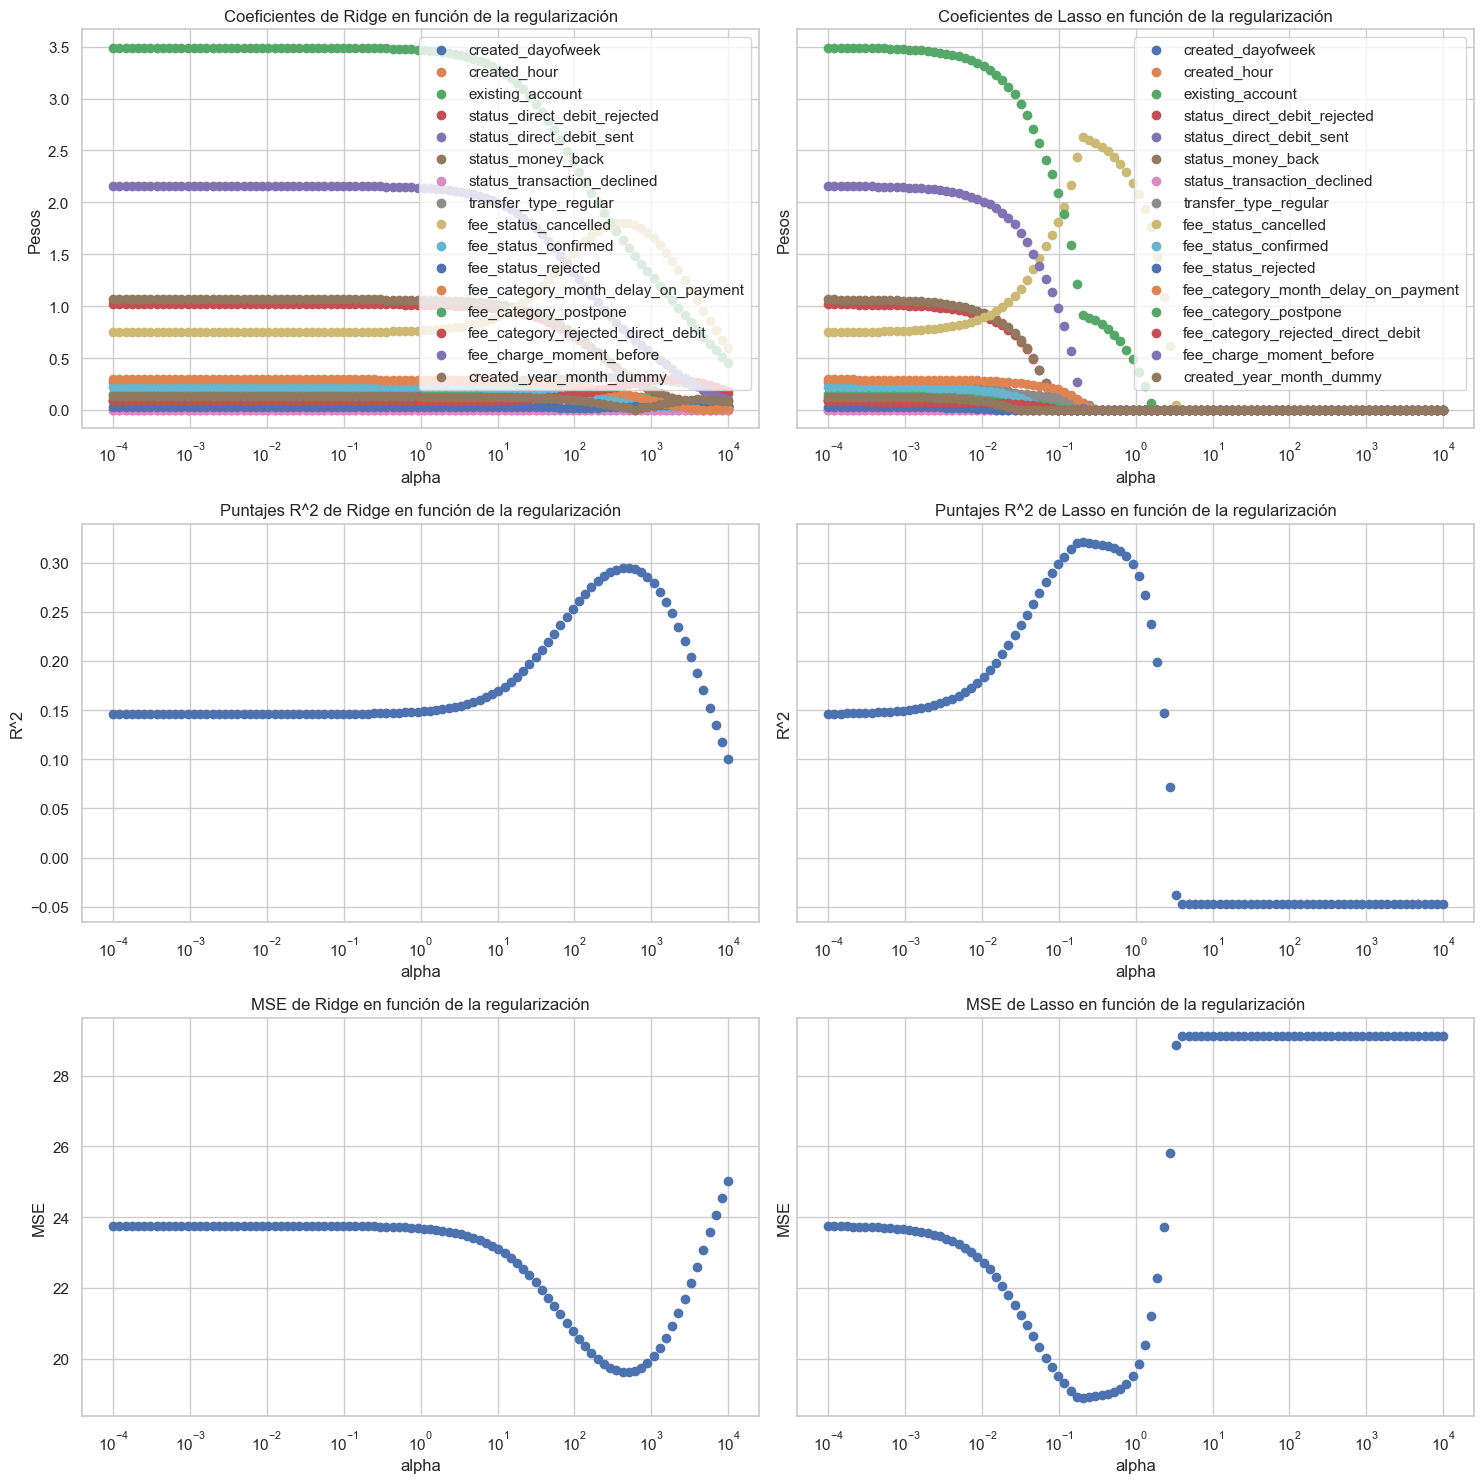

In [47]:
# Búsqueda de Hiperparámetros
# Parámetros
n_alphas = 100
alphas = np.logspace(-4, 4, n_alphas)
np.random.seed(seed)
np.random.shuffle(alphas)

# Inicialización de listas para almacenar coeficientes, puntajes R^2 y MSE
coefs_ridge = []
r2_ridge = []
mse_ridge = []
coefs_lasso = []
r2_lasso = []
mse_lasso = []

# Para Ridge
for l in alphas:
    regr_ridge = linear_model.Ridge(alpha=l, tol = 0.01) # Crear un regresor Ridge
    regr_ridge.fit(X_train_std, y_train) # Ajustar el modelo
    coefs_ridge.append(regr_ridge.coef_)
    r2_ridge.append(regr_ridge.score(X_test_std, y_test)) # Puntaje R^2 para cada alpha
    mse_ridge.append(mean_squared_error(y_test, regr_ridge.predict(X_test_std))) # MSE para cada alpha

# Para Lasso
for l in alphas:
    regr_lasso = linear_model.Lasso(alpha=l, tol = 0.01) # Crear un regresor Lasso
    regr_lasso.fit(X_train_std, y_train) # Ajustar el modelo
    coefs_lasso.append(regr_lasso.coef_)
    r2_lasso.append(regr_lasso.score(X_test_std, y_test)) # Puntaje R^2 para cada alpha
    mse_lasso.append(mean_squared_error(y_test, regr_lasso.predict(X_test_std))) # MSE para cada alpha

fig, axs = plt.subplots(3, 2, figsize=(15, 15), sharey='row')

# Coeficientes de Ridge
for coef in np.abs(coefs_ridge).T:
    axs[0,0].scatter(alphas, coef)
    axs[0,0].set_xscale('log')
    axs[0,0].set_title('Coeficientes de Ridge en función de la regularización')
    axs[0,0].axis('tight')
    axs[0,0].set_xlabel('alpha')
    axs[0,0].set_ylabel('Pesos')
    axs[0,0].legend(features)

# Coeficientes de Lasso
for coef in np.abs(coefs_lasso).T:
    axs[0,1].scatter(alphas, coef)
    axs[0,1].set_xscale('log')
    axs[0,1].set_title('Coeficientes de Lasso en función de la regularización')
    axs[0,1].axis('tight')
    axs[0,1].set_xlabel('alpha')
    axs[0,1].set_ylabel('Pesos')
    axs[0,1].legend(features)

# Scores de Ridge
axs[1,0].scatter(alphas, r2_ridge)
axs[1,0].set_xscale('log')
axs[1,0].set_title('Puntajes R^2 de Ridge en función de la regularización')
axs[1,0].axis('tight')
axs[1,0].set_xlabel('alpha')
axs[1,0].set_ylabel('R^2')

# Scores de Lasso
axs[1,1].scatter(alphas, r2_lasso)
axs[1,1].set_xscale('log')
axs[1,1].set_title('Puntajes R^2 de Lasso en función de la regularización')
axs[1,1].axis('tight')
axs[1,1].set_xlabel('alpha')
axs[1,1].set_ylabel('R^2')

# MSE de Ridge
axs[2,0].scatter(alphas, mse_ridge)
axs[2,0].set_xscale('log')
axs[2,0].set_title('MSE de Ridge en función de la regularización')
axs[2,0].axis('tight')
axs[2,0].set_xlabel('alpha')
axs[2,0].set_ylabel('MSE')

# MSE de Lasso
axs[2,1].scatter(alphas, mse_lasso)
axs[2,1].set_xscale('log')
axs[2,1].set_title('MSE de Lasso en función de la regularización')
axs[2,1].axis('tight')
axs[2,1].set_xlabel('alpha')
axs[2,1].set_ylabel('MSE')
plt.tight_layout()
plt.show()    

In [54]:
# Selección de alpha óptimo para Ridge basado en R^2
max_index_ridge_r2 = np.argmax(r2_ridge) # Encontrar el índice del máximo R^2
best_alpha_ridge_r2 = alphas[max_index_ridge_r2] # Encontrar el alpha correspondiente
best_r2_ridge = r2_ridge[max_index_ridge_r2] # Puntaje R^2 correspondiente al máximo
# Selección de alpha óptimo para Ridge basado en MSE
min_index_ridge_mse = np.argmin(mse_ridge) # Encontrar el índice del mínimo MSE
best_alpha_ridge_mse = alphas[min_index_ridge_mse] # Encontrar el alpha correspondiente
best_mse_ridge = mse_ridge[min_index_ridge_mse] # Puntaje MSE correspondiente al mínimo

# Selección de alpha óptimo para Lasso basado en R^2
max_index_lasso_r2 = np.argmax(r2_lasso) # Encontrar el índice del máximo R^2
best_alpha_lasso_r2 = alphas[max_index_lasso_r2] # Encontrar el alpha correspondiente
best_r2_lasso = r2_lasso[max_index_lasso_r2] # Puntaje R^2 correspondiente al máximo
# Selección de alpha óptimo para Lasso basado en MSE
min_index_lasso_mse = np.argmin(mse_lasso) # Encontrar el índice del mínimo MSE
best_alpha_lasso_mse = alphas[min_index_lasso_mse] # Encontrar el alpha correspondiente
best_mse_lasso = mse_lasso[min_index_lasso_mse] # Puntaje MSE correspondiente al mínimo

# Crear un DataFrame con los resultados
resultados = {
    'Modelo': ['Ridge', 'Lasso'],
    'Índice del mejor R^2': [max_index_ridge_r2, max_index_lasso_r2],
    'Mejor alpha encontrado (R^2)': [best_alpha_ridge_r2, best_alpha_lasso_r2],
    'Puntaje R^2 máximo obtenido': [best_r2_ridge, best_r2_lasso],
    'Índice del mejor MSE': [min_index_ridge_mse, min_index_lasso_mse],
    'Mejor alpha encontrado (MSE)': [best_alpha_ridge_mse, best_alpha_lasso_mse],
    'Puntaje MSE mínimo obtenido': [best_mse_ridge, best_mse_lasso]
}

# Crear DataFrame
df_resultados = pd.DataFrame(resultados)
# Mostrar el DataFrame con los resultados
df_resultados

,Modelo,Índice del mejor R^2,Mejor alpha encontrado (R^2),Puntaje R^2 máximo obtenido,Índice del mejor MSE,Mejor alpha encontrado (MSE),Puntaje MSE mínimo obtenido
0,Ridge,0,509.413801,0.294687,0,509.413801,19.620806
1,Lasso,71,0.205651,0.321267,71,0.205651,18.881375


In [55]:
# Evaluación General del Modelo
# Crear un diccionario con los datos en una sola fila
data = {
    'R2_Entrenamiento': [r2score_train],
    'R2_Prueba': [r2score_test],
    'Diferencia_R2': [r2score_train - r2score_test]
}
# Crear el DataFrame
df_r2_scores = pd.DataFrame(data)
# Mostrar el DataFrame
df_r2_scores

,R2_Entrenamiento,R2_Prueba,Diferencia_R2
0,0.26958,0.145935,0.123646


In [56]:
# Entrenamiento de Lasso con el Mejor Alpha Encontrado
best_alpha_lasso_r2 = 0.205651
lasso = linear_model.Lasso(alpha=best_alpha_lasso_r2)
lasso.fit(X_train_std, y_train)
coefs = pd.Series(np.abs(lasso.coef_), features).sort_values(ascending=False)
coefs

fee_status_cancelled                   2.484971
fee_category_postpone                  1.090172
fee_charge_moment_before               0.147549
fee_category_month_delay_on_payment    0.074471
transfer_type_regular                  0.066009
created_dayofweek                      0.000000
created_hour                           0.000000
existing_account                       0.000000
status_direct_debit_rejected           0.000000
status_direct_debit_sent               0.000000
status_money_back                      0.000000
status_transaction_declined            0.000000
fee_status_confirmed                   0.000000
fee_status_rejected                    0.000000
fee_category_rejected_direct_debit     0.000000
created_year_month_dummy               0.000000
dtype: float64

In [57]:
df = pd.DataFrame(X_train_std, columns=features)
df['targ'] = y_train
df.head()

,created_dayofweek,created_hour,existing_account,status_direct_debit_rejected,status_direct_debit_sent,status_money_back,status_transaction_declined,transfer_type_regular,fee_status_cancelled,fee_status_confirmed,fee_status_rejected,fee_category_month_delay_on_payment,fee_category_postpone,fee_category_rejected_direct_debit,fee_charge_moment_before,created_year_month_dummy,targ
0,-1.510990,-0.111160,0.261644,-0.101201,0.0,0.114661,0.0,-0.712274,-0.600772,-0.0349,-0.118238,-0.18073,-0.955568,-0.432769,-0.559553,1.080753,NaN
1,-0.423077,0.077369,0.261644,-0.101201,0.0,0.114661,0.0,-0.712274,1.664525,-0.0349,-0.118238,-0.18073,1.046498,-0.432769,1.787142,1.080753,NaN
2,0.120879,0.077369,0.261644,-0.101201,0.0,0.114661,0.0,1.403953,1.664525,-0.0349,-0.118238,-0.18073,1.046498,-0.432769,-0.559553,-1.544998,NaN
3,-0.967033,1.397069,0.261644,-0.101201,0.0,0.114661,0.0,-0.712274,1.664525,-0.0349,-0.118238,-0.18073,1.046498,-0.432769,-0.559553,1.080753,NaN
4,1.208792,0.077369,0.261644,-0.101201,0.0,0.114661,0.0,1.403953,1.664525,-0.0349,-0.118238,-0.18073,1.046498,-0.432769,-0.559553,-0.669748,NaN


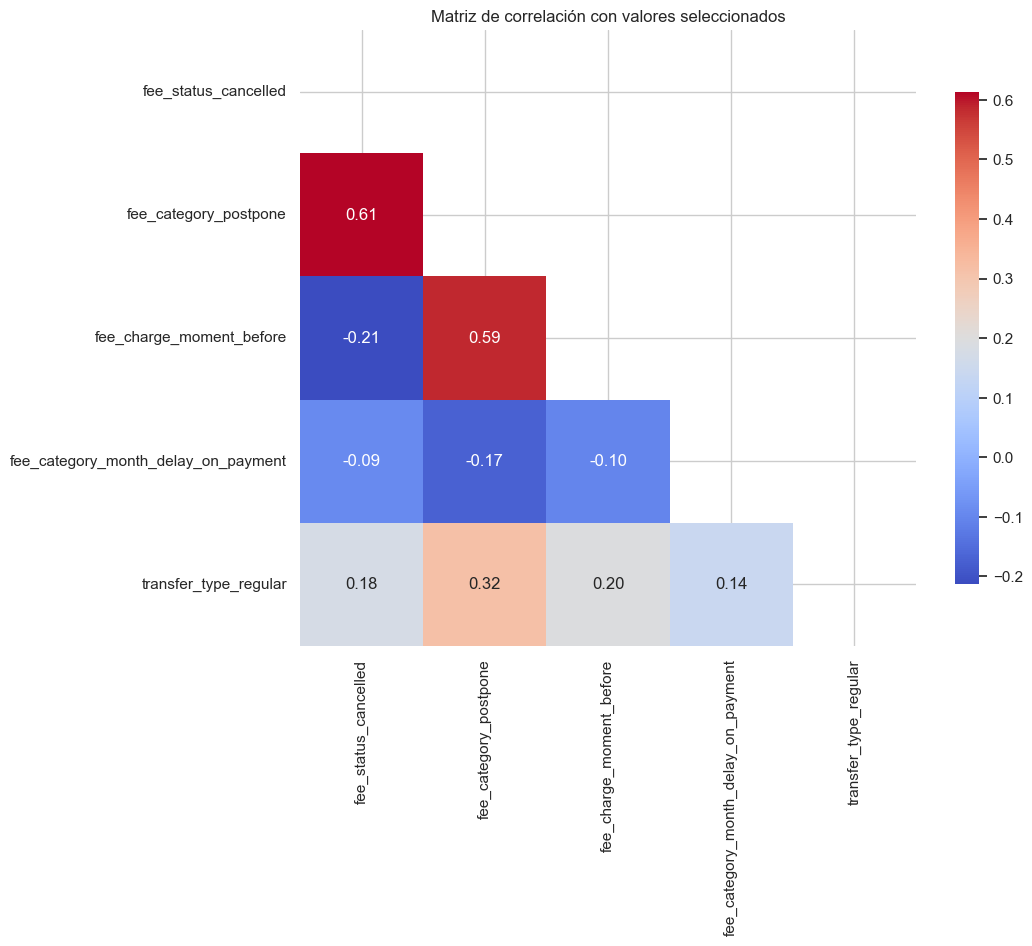

In [63]:
# Crear una matriz de correlación para las variables de interés
variables_de_interes = ['fee_status_cancelled','fee_category_postpone','fee_charge_moment_before','fee_category_month_delay_on_payment','transfer_type_regular']
correlacion = df[variables_de_interes].corr()
# Configurar el tamaño de la figura
plt.figure(figsize=(10, 8))
# Crear el mapa de calor con valores numéricos sobre cada cuadro
mask = np.triu(np.ones_like(correlacion, dtype=bool))
sns.heatmap(correlacion, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={'shrink': .8})
# Añadir título a la gráfica
plt.title('Matriz de correlación con valores seleccionados')
# Mostrar la gráfica
plt.show()

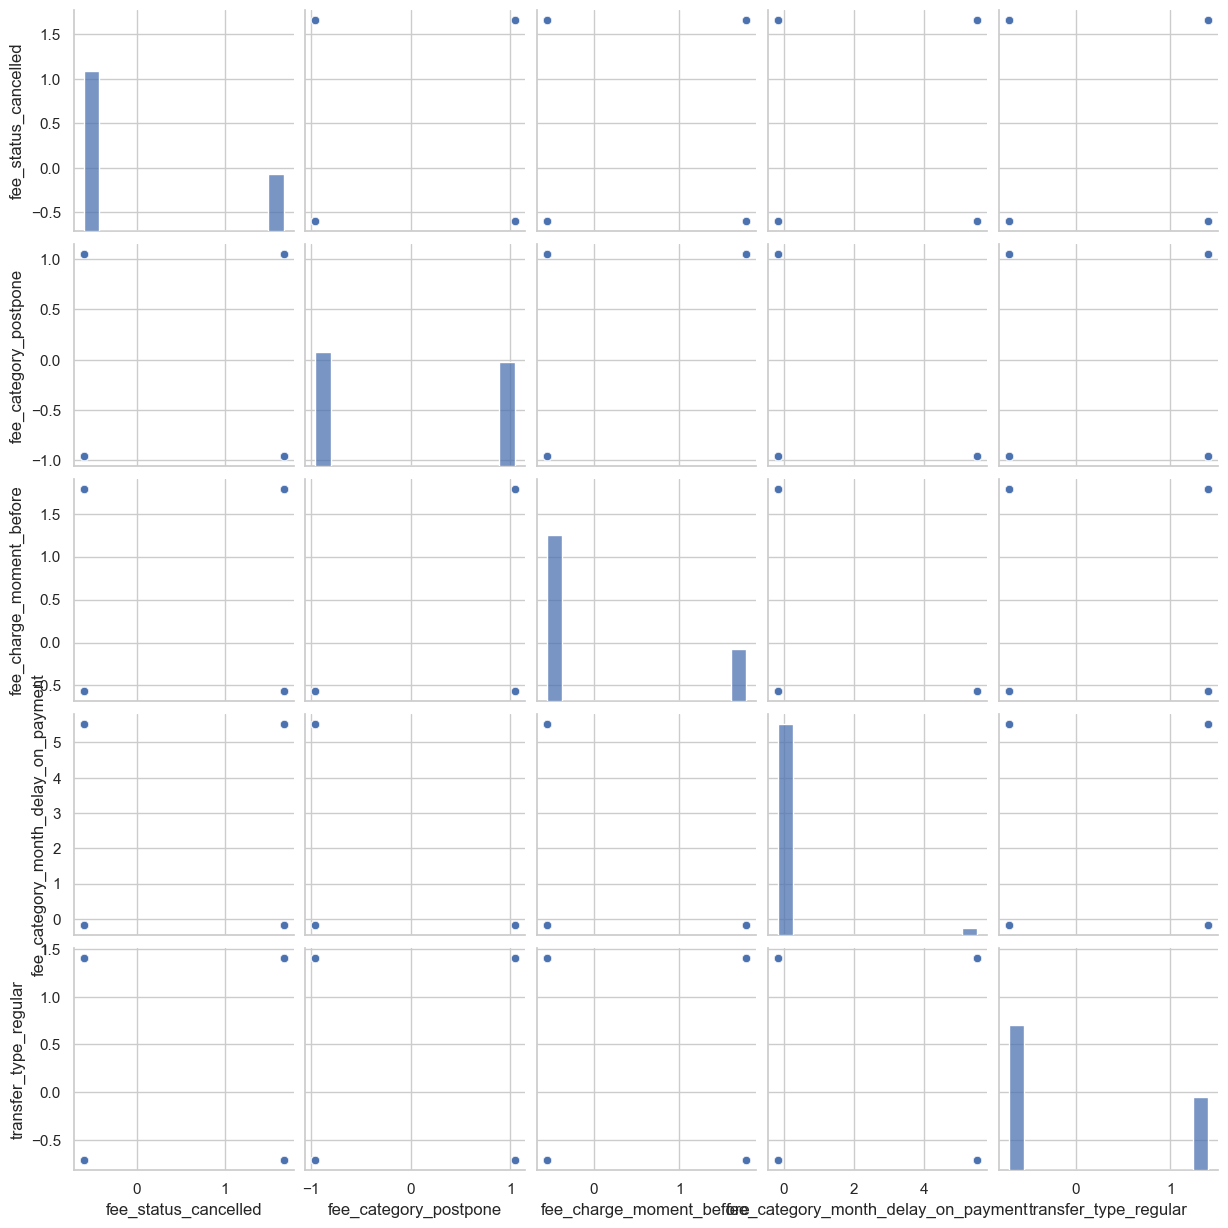

In [64]:
sns.pairplot(df[variables_de_interes])

In [65]:
# Selección de Características con SKLearn
# Creación del selector de características:
# - Se instancia un objeto SelectKBest con el parámetro score_func=fs.f_regression
# para usar la prueba f_regression, que evalúa la dependencia lineal entre cada carac-
# terística y la variable objetivo.
# - Se especifica k=5 para seleccionar las 5 mejores características según las puntuaciones
# obtenidas.

# Este proceso ayuda a identificar qué características son más relevantes para el modelo de regresión,
# lo cual es crucial para mejorar la precisión y la interpretación del modelo en la predicción de la
# variable objetivo.

import sklearn.feature_selection as fs
import numpy as np

# Crear el selector de características
selector = fs.SelectKBest(score_func=fs.f_regression, k=5)

# Aplicar el selector a los datos de entrenamiento y prueba
X_new_train = selector.fit_transform(X_train, y_train)
X_new_test = selector.transform(X_test)

# Obtener los índices de las características seleccionadas
selected_features_indices = selector.get_support(indices=True)

# Obtener los nombres de características relevantes y no importantes
relevant_features = np.array(features)[selected_features_indices]
non_important_features = np.array(features)[np.logical_not(selector.get_support())]
print('Variables no importantes: {}'.format(non_important_features))
print('Variables relevantes: {}'.format(relevant_features))

Variables no importantes: ['created_dayofweek' 'created_hour' 'existing_account'
 'status_direct_debit_rejected' 'status_direct_debit_sent'
 'status_money_back' 'status_transaction_declined' 'fee_status_confirmed'
 'fee_status_rejected' 'fee_category_month_delay_on_payment'
 'fee_charge_moment_before']
Variables relevantes: ['transfer_type_regular' 'fee_status_cancelled' 'fee_category_postpone'
 'fee_category_rejected_direct_debit' 'created_year_month_dummy']


In [66]:
X_new_train.shape

(2466, 5)

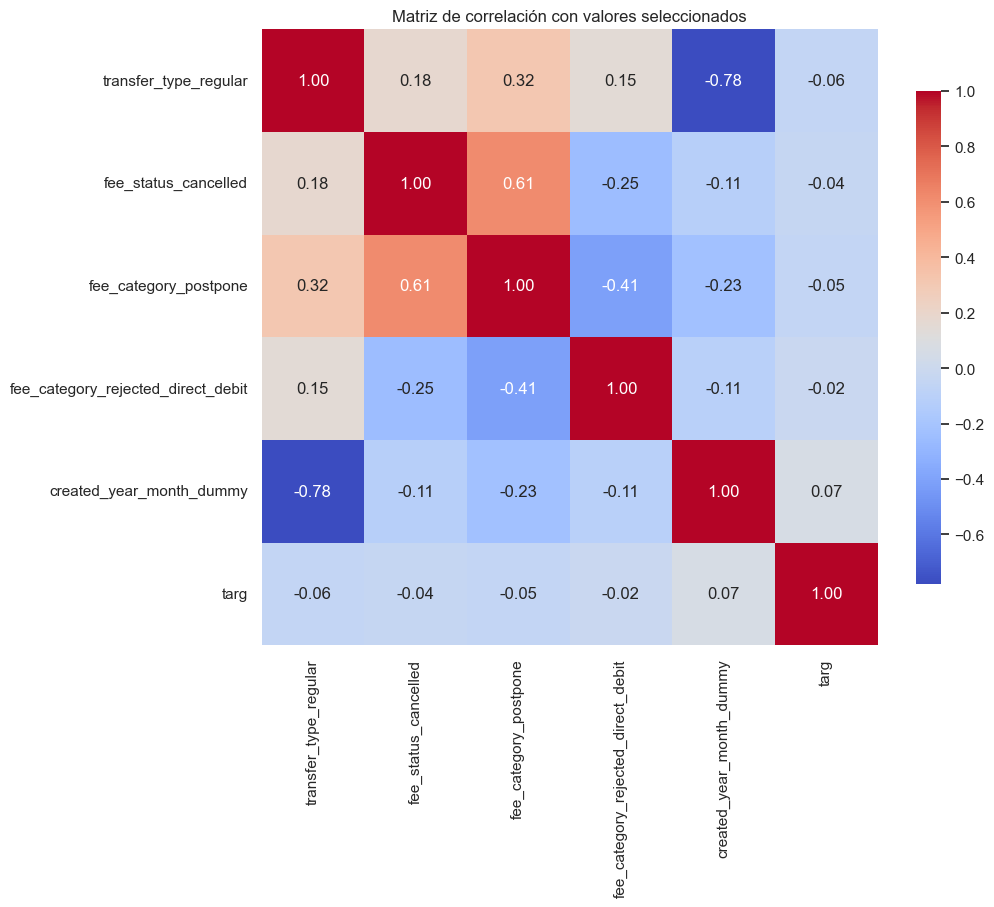

In [67]:
# Crear una matriz de correlación para las variables de interés
correlacion = df[relevant_features.tolist() + ['targ']].corr()
# Configurar el tamaño de la figura
plt.figure(figsize=(10, 8))
# Crear el mapa de calor con valores numéricos sobre cada cuadro
sns.heatmap(correlacion, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={'shrink': .8})
# Añadir título a la gráfica
plt.title('Matriz de correlación con valores seleccionados')
# Mostrar la gráfica
plt.show()

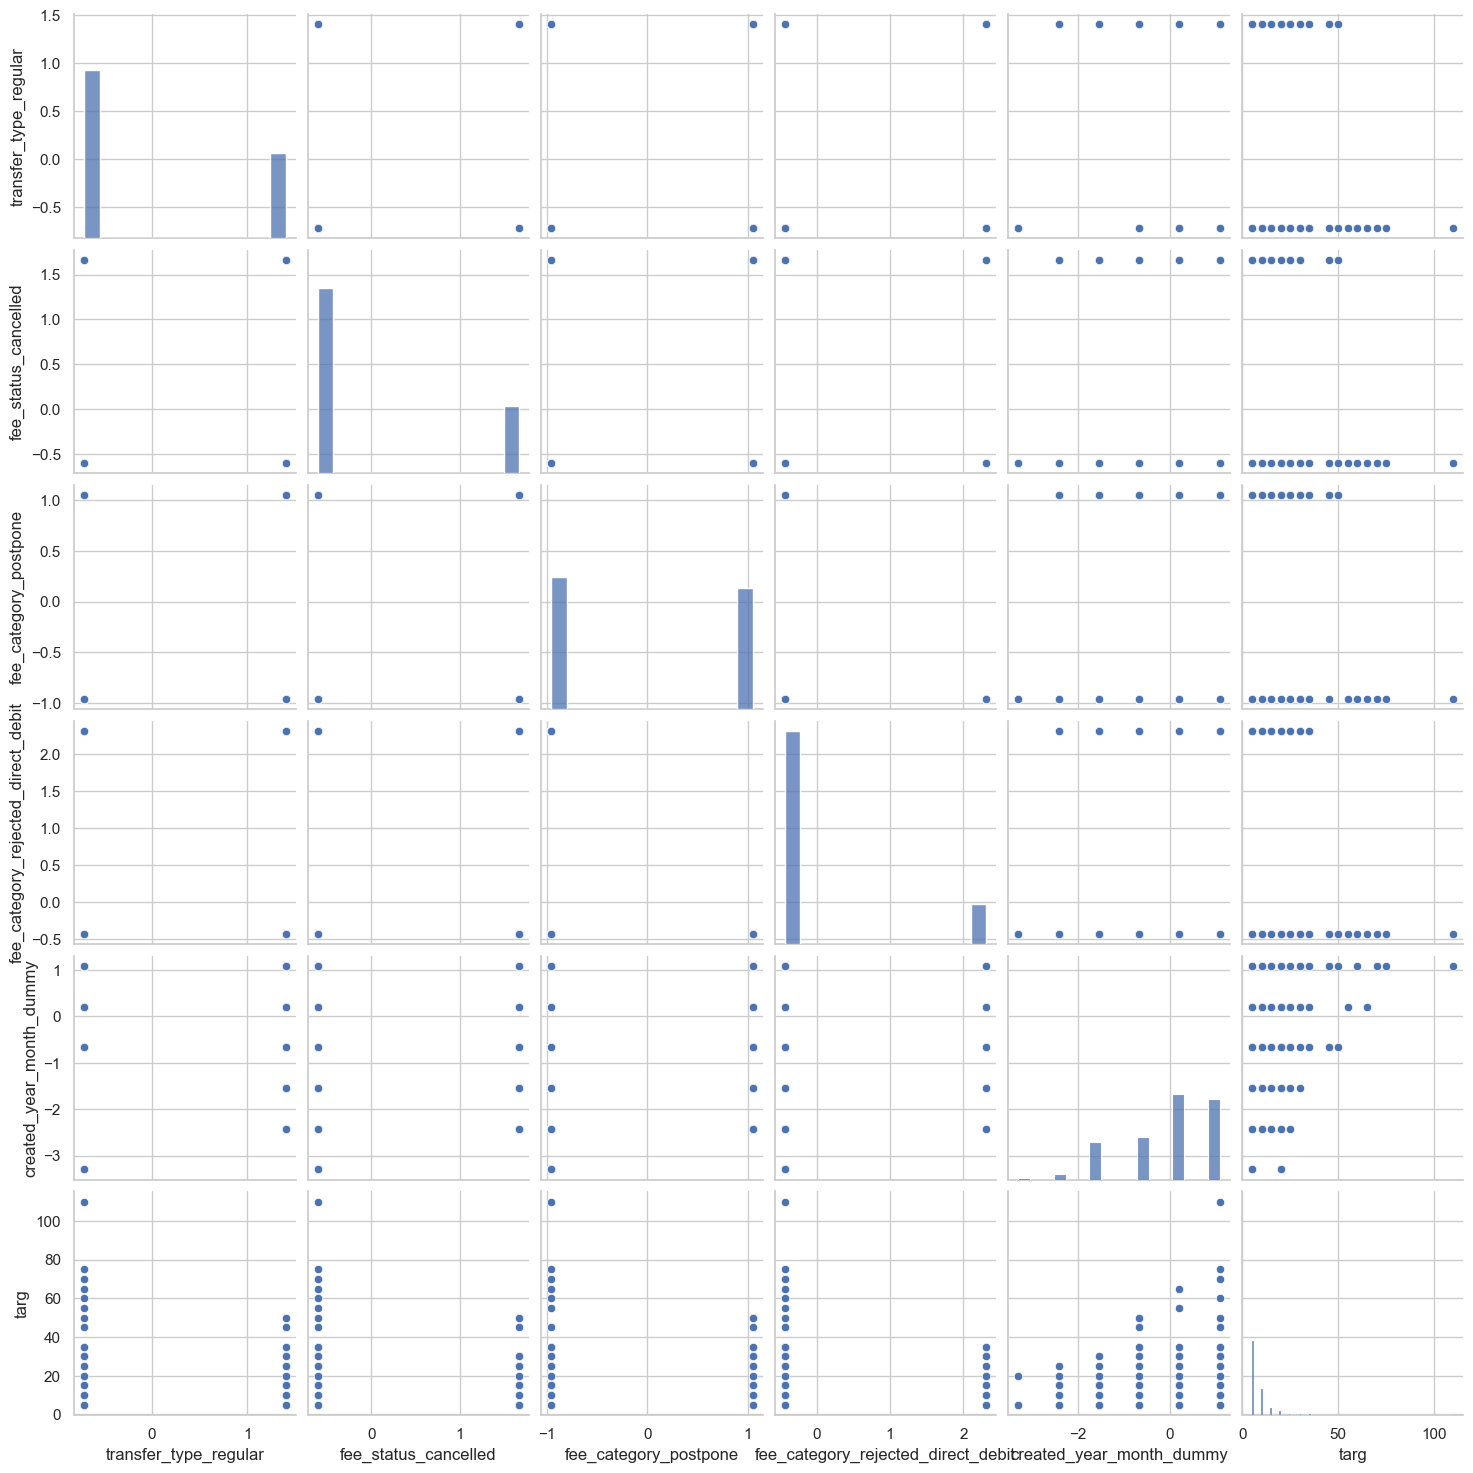

In [68]:
sns.pairplot(df[relevant_features.tolist() + ['targ']])